Based on [qiskit lab](https://qiskit.org/textbook/ch-algorithms/teleportation.html) and [qbronze lab](https://gitlab.com/qworld/bronze-qiskit/-/blob/master/quantum-with-qiskit/Q76_Quantum_Teleportation.ipynb).

## How it works?

### What do we want

$|\psi\rangle\otimes|00\rangle \rightarrow |00\psi\rangle$

### Idea of teleportation

Having an entagled pair of qubits, shared between to participants, transer a state on arbitrary qubit to the state of reciever.

$|\psi\rangle\otimes|00\rangle \rightarrow |\psi\rangle\otimes\frac{1}{\sqrt{2}}\left(|00\rangle+|11\rangle\right) \rightarrow |00\psi\rangle$

### [offtopic] A simple and straightforward solution...

... which might work. But no.

$U|\psi 00\rangle = |00\psi\rangle$

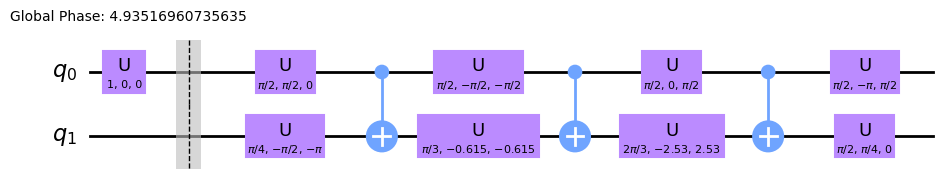

In [17]:
from qiskit import transpile, QuantumCircuit, BasicAer
import numpy as np

# the matix should run like 
matrix = np.array([
    [1., 0., 0., 0.],
    [0., 0., 1., 0.],
    [0., 1., 0., 0.],
    [0., 0., 0., 1.],
])
# do we know this matrix?

qc = QuantumCircuit(2)
qc.ry(1.0, 0)
qc.barrier()
qc.unitary(matrix, [0, 1])

transpile(qc, BasicAer.get_backend("statevector_simulator")).decompose().decompose().draw('mpl')

_**Q**: What is wrong with this circuits? Can you describe a teleportation protocol?_

### Idea of a textbook implementation

$(\alpha|0\rangle+\beta|1\rangle)\otimes\frac{1}{\sqrt{2}}\left(|00\rangle+|11\rangle\right)$

$\frac{1}{\sqrt{2}}(\alpha|000\rangle+\beta|100\rangle+\alpha|011\rangle+\beta|111\rangle)$

$\frac{1}{\sqrt{2}}(\alpha|00\rangle\otimes|0\rangle+\beta|10\rangle\otimes|0\rangle+\alpha|01\rangle\otimes|1\rangle+\beta|11\rangle\otimes|1\rangle)$


Measure the teleported (sender's) qubit and the entangled one in Bell's basis. If we observe the state in $|\Phi^+\rangle=\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$. 

$\langle\Phi^+|\times \frac{1}{\sqrt{2}}(\alpha|00\rangle\otimes|0\rangle+\beta|10\rangle\otimes|0\rangle+\alpha|01\rangle\otimes|1\rangle+\beta|11\rangle\otimes|1\rangle)$

**NB!!**: Note, that the formula below is "kind of an a-priori distribution for $|\psi\rangle$", as soon as we just selected the conditional observation. To get aposteriori state vector, we must divide resulting distribution by a probability of $|\Phi^+\rangle$ (which is $\frac{1}{4}$), but as state vector encodes the amplitudes, we will see that the term $\sqrt{\frac{1}{4}} = \frac{1}{2}$ will pop in the end.


$\frac{1}{\sqrt{2}}(\alpha\langle\Phi^+|00\rangle\otimes|0\rangle+\beta\langle\Phi^+|10\rangle\otimes|0\rangle+\alpha\langle\Phi^+|01\rangle\otimes|1\rangle+\beta\langle\Phi^+|11\rangle\otimes|1\rangle)$

Middle terms are impossible to observe (there are no $|01\rangle$ or $|10\rangle$ components in $|\Phi^+\rangle$ state). Both other have equal probability and $\langle\Phi^+|00\rangle=\frac{1}{\sqrt{2}}\langle 00|00\rangle+\frac{1}{\sqrt{2}}\langle 11|00\rangle=\frac{1}{\sqrt{2}}$

$\frac{1}{\sqrt{2}} \left(\alpha\frac{1}{\sqrt{2}}|0\rangle + \beta\frac{1}{\sqrt{2}}|1\rangle\right)$

But what if the observed state is $|\Psi^-\rangle$? We have $\beta |0\rangle - \alpha |1\rangle$ state. We will need to fix the phase with $Z$ (to fix minus to plus) and negate a qubit with $X$!

### Implementation time!

Learn what is [`c_if(classic, value)`](https://quantumcomputing.stackexchange.com/questions/9372/how-to-implement-if-statement-based-on-measurement-results-in-qiskit) condition and how to apply it.

Entangle


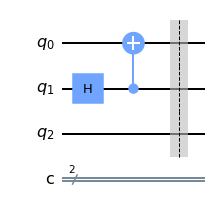

Send one to reciever


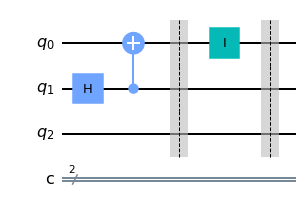

What will we teleport? Prepare SOME state


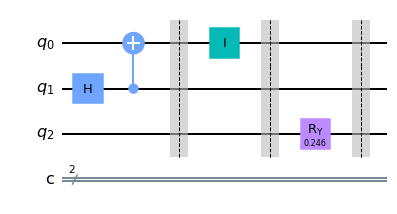

Measure on sender's side in Bell's basis


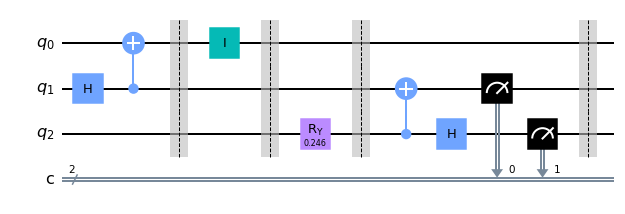

Post-processing: if state is different from Ф+


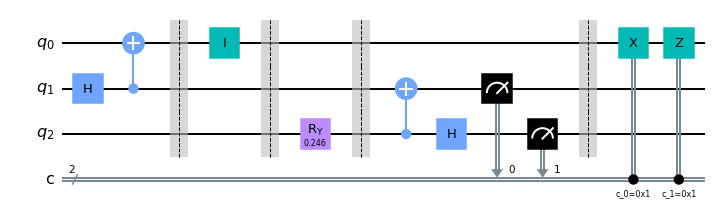

the state vector is
[0.       0.       0.992445 0.12269  0.       0.       0.       0.      ]
Look here >>>>>>>>>>>>>>>: 0.1230002619213948


In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, BasicAer
import matplotlib.pyplot as plt
import qiskit
# sv = qiskit.quantum_info.random_statevector(2)

# quantum circuit with three qubits and two bits
qr =  QuantumRegister(3, "q") 
cr = ClassicalRegister(2, "c") 
qc = QuantumCircuit(qr, cr)

alice, media, bob = qr[::-1]

# creating an entanglement between q[1] and q[0]
print("Entangle")
qc.h(media)
qc.cx(media, bob)
qc.barrier()

display(qc.draw(output='mpl'))

# transfer one of qubits to recieving party
print("Send one to reciever")
qc.i(bob)
qc.barrier()

display(qc.draw(output='mpl'))

# prepare a qubit on sender's side
print("What will we teleport? Prepare SOME state")
qc.ry(0.123 * 2, alice)
qc.barrier()

display(qc.draw(output='mpl'))

# measure the qubit in Bell state
print("Measure on sender's side in Bell's basis")
qc.cx(alice, media)
qc.h(alice)
qc.measure([media, alice], cr)  # 2 last qubits
qc.barrier()

display(qc.draw(output='mpl'))

print("Post-processing: if state is different from Ф+")
qc.x(bob).c_if(cr[0], 1)
qc.z(bob).c_if(cr[1], 1)

display(qc.draw(output='mpl'))

# read the state vector
job = execute(qc, BasicAer.get_backend('statevector_simulator'), optimization_level=0, shots=1)
current_quantum_state = abs(job.result().get_statevector(qc, decimals=6))
print("the state vector is")
print(current_quantum_state)

i = 0
while current_quantum_state[i] == 0.0:
    i += 1

cos = current_quantum_state[i]
from math import acos
print("Look here >>>>>>>>>>>>>>>:", acos(cos))

[IBM](https://qiskit.org/textbook/ch-algorithms/teleportation.html): The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. Fortunately, this does not limit our ability to perform any computations due to the deferred measurement principle discussed in chapter 4.4 of [this book](http://mmrc.amss.cas.cn/tlb/201702/W020170224608149940643.pdf). The principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results.

